<a href="https://colab.research.google.com/github/MoqiSheng/MoqiSheng.github.io/blob/main/%E6%AF%8F%E4%B8%AA%E5%8A%9F%E8%83%BD%E7%9A%84%E5%87%A0%E4%BD%95%E4%B8%AD%E4%BD%8D%E6%95%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CommonFeatures/correct_function.zip -d /content/Data

Archive:  /content/drive/MyDrive/CommonFeatures/correct_function.zip
   creating: /content/Data/civic, governmental and cultural/
  inflating: /content/Data/civic, governmental and cultural/0.png  
  inflating: /content/Data/civic, governmental and cultural/1035.png  
  inflating: /content/Data/civic, governmental and cultural/1056.png  
  inflating: /content/Data/civic, governmental and cultural/1219.png  
  inflating: /content/Data/civic, governmental and cultural/1246.png  
  inflating: /content/Data/civic, governmental and cultural/1266.png  
  inflating: /content/Data/civic, governmental and cultural/1272.png  
  inflating: /content/Data/civic, governmental and cultural/1286.png  
  inflating: /content/Data/civic, governmental and cultural/1287.png  
  inflating: /content/Data/civic, governmental and cultural/1288.png  
  inflating: /content/Data/civic, governmental and cultural/1289.png  
  inflating: /content/Data/civic, governmental and cultural/1290.png  
  inflating: /content

In [ ]:
import os
import torch
from transformers import ViTModel, ViTFeatureExtractor
from PIL import Image
from tqdm import tqdm
import pandas as pd

# 设置设备为 GPU（如果可用）
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {device}")

# 加载预训练的 ViT 模型和特征提取器
model_name = "google/vit-base-patch16-224-in21k"
print(f"加载预训练模型: {model_name}...")
model = ViTModel.from_pretrained(model_name).to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model.eval()  # 设置模型为评估模式
print("预训练模型加载完成。")

# 定义特征提取函数
def extract_features(image_folder, output_file):
    image_features_list = []
    image_filenames = []

    # 获取并按文件名中的数字顺序排序图像路径
    image_paths = sorted(
        [
            os.path.join(image_folder, img)
            for img in os.listdir(image_folder)
            if img.lower().endswith(('.jpg', '.jpeg', '.png'))
        ],
        key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
    )

    print(f"在文件夹 {image_folder} 中找到 {len(image_paths)} 张图像。")

    # 处理每一张图像
    for image_path in tqdm(image_paths, desc=f"处理 {image_folder}"):
        try:
            # 加载并预处理图像
            image = Image.open(image_path).convert("RGB")
            inputs = feature_extractor(images=image, return_tensors="pt")
            image_input = inputs['pixel_values'].to(device)  # 获取像素值并移动到设备

            # 禁用梯度计算，提高效率
            with torch.no_grad():
                outputs = model(image_input)
                # 通常使用 [CLS] 标记的隐藏状态作为图像特征
                image_features = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]
                image_features /= image_features.norm(dim=-1, keepdim=True)  # 归一化特征向量

            # 将特征移动到 CPU 并添加到列表中
            image_features_list.append(image_features.cpu())
            image_filenames.append(os.path.basename(image_path))

        except Exception as e:
            print(f"处理 {image_path} 时出错: {e}")

    # 将所有特征拼接成一个大的张量
    if image_features_list:
        image_features = torch.cat(image_features_list, dim=0)  # [num_images, feature_dim]
        torch.save(image_features, output_file)
        print(f"特征已保存到 {output_file}")
    else:
        print(f"在 {image_folder} 中未找到有效的图像")
        return None, None

    return image_features, image_filenames

# 定义计算余弦相似度并保存为 CSV 的函数
def compute_and_save_cosine_similarity(features, filenames, csv_output):
    if features is None or filenames is None:
        print("特征或文件名为空，无法计算余弦相似度。")
        return

    print("计算余弦相似度矩阵...")

    # 余弦相似度可以通过特征矩阵与其转置的点积计算（假设特征已经归一化）
    similarity_matrix = torch.mm(features, features.t()).numpy()  # [num_images, num_images]

    print(f"相似度矩阵大小: {similarity_matrix.shape}")

    # 将相似度矩阵转换为 DataFrame
    df = pd.DataFrame(similarity_matrix, index=filenames, columns=filenames)

    # 保存为 CSV 文件
    df.to_csv(csv_output)
    print(f"余弦相似度矩阵已保存到 {csv_output}")

# 主流程
if __name__ == "__main__":
    # 定义图像文件夹和输出文件路径
    image_folder = './Data/transportation'
    feature_output = './imgs_vit_transportation.pt'
    csv_output = './cosine_similarity_matrix_transportation.csv'

    # 确保输出目录存在
    os.makedirs(os.path.dirname(feature_output), exist_ok=True)
    os.makedirs(os.path.dirname(csv_output), exist_ok=True)

    # 提取特征
    features, filenames = extract_features(image_folder, feature_output)

    # 计算余弦相似度并保存为 CSV
    compute_and_save_cosine_similarity(features, filenames, csv_output)


使用设备: cuda
加载预训练模型: google/vit-base-patch16-224-in21k...


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


预训练模型加载完成。
在文件夹 ./Data/transportation 中找到 47 张图像。


处理 ./Data/transportation: 100%|██████████| 47/47 [00:00<00:00, 59.41it/s]

特征已保存到 ./imgs_vit_transportation.pt
计算余弦相似度矩阵...
相似度矩阵大小: (47, 47)
余弦相似度矩阵已保存到 ./cosine_similarity_matrix_transportation.csv


加载图像特征和文件名...
加载完成，共有 208 张图像，特征维度为 768。
应用 PCA 提取前 50 个主成分作为共同特征...


<ipython-input-6-6e7f7287ad34>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(feature_path)  # [num_images, feature_dim]


PCA 提取完成。
绘制累计解释方差比例图...


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37322 (\N{CJK UNIFIED IDEOGRAPH-91CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

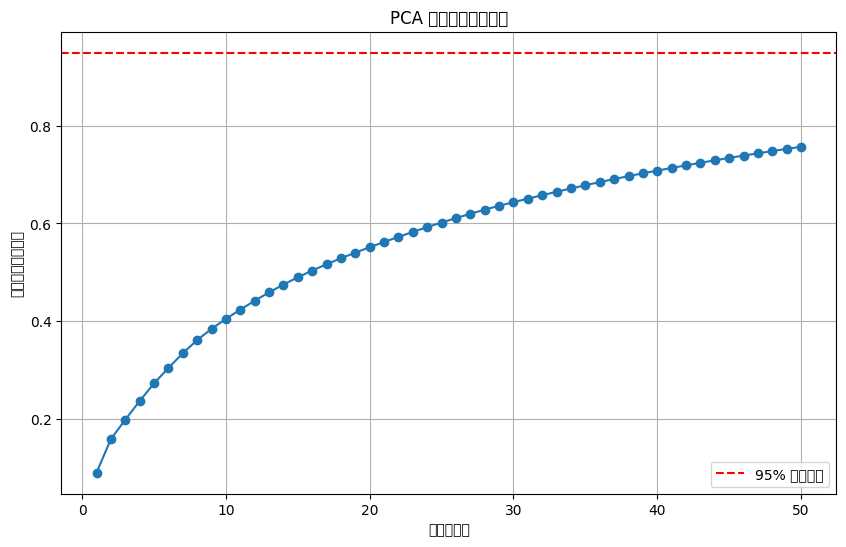

选择前 10 个主成分作为共同特征。
归一化共同特征...
可视化前两个主成分的分布...


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20004 (\N{CJK UNIFIED IDEOGRAPH-4E24}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


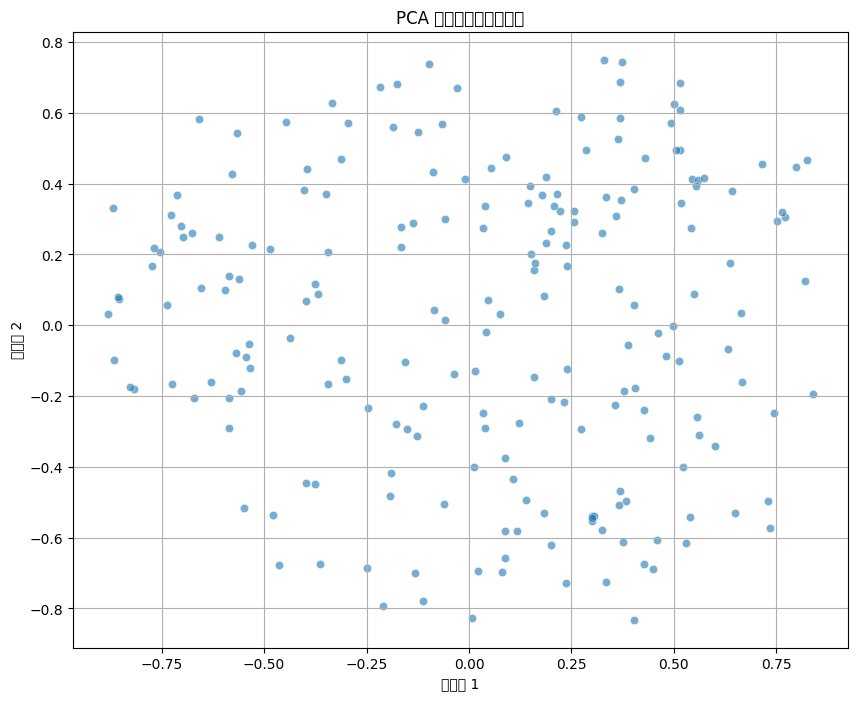

保存共同特征...
共同特征已保存到 ./common_features_pca.pt
计算共同特征的平均余弦相似度...
共同特征的平均余弦相似度: -0.0026


In [ ]:
import os
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_features(feature_path, csv_path):
    """
    加载图像特征和文件名。
    """
    if not os.path.exists(feature_path):
        raise FileNotFoundError(f"特征文件 {feature_path} 不存在。")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV 文件 {csv_path} 不存在。")

    features = torch.load(feature_path)  # [num_images, feature_dim]
    df = pd.read_csv(csv_path, index_col=0)  # 假设 CSV 的第一列是索引（文件名）
    filenames = df.columns.tolist()  # 假设 CSV 的列名为图像文件名

    if features.shape[0] != len(filenames):
        raise ValueError("特征数量与文件名数量不匹配。")

    return features, filenames

def apply_pca(features, n_components=50):
    """
    对特征应用 PCA 并提取共同特征。
    """
    features_np = features.numpy()
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(features_np)
    features_pca = pca.transform(features_np)
    return pca, features_pca

def plot_explained_variance(pca, n_components):
    """
    绘制累计解释方差比例图。
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
    plt.xlabel('主成分数量')
    plt.ylabel('累计解释方差比例')
    plt.title('PCA 累计解释方差比例')
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% 解释方差')
    plt.legend()
    plt.show()

def visualize_pca_2d(features_pca):
    """
    使用前两个主成分可视化特征分布。
    """
    if features_pca.shape[1] < 2:
        raise ValueError("PCA 特征数量不足以进行 2D 可视化。")

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.xlabel('主成分 1')
    plt.ylabel('主成分 2')
    plt.title('PCA 前两个主成分的分布')
    plt.grid(True)
    plt.show()

def save_common_features(common_features, output_path):
    """
    保存共同特征到 .pt 文件。
    """
    torch.save(torch.tensor(common_features, dtype=torch.float32), output_path)
    print(f"共同特征已保存到 {output_path}")

def calculate_average_cosine_similarity(common_features):
    """
    计算共同特征的平均余弦相似度。
    """
    similarity_matrix = np.dot(common_features, common_features.T)
    norms = np.linalg.norm(common_features, axis=1, keepdims=True)
    similarity_matrix = similarity_matrix / (norms * norms.T)
    np.fill_diagonal(similarity_matrix, 0)  # 排除自身相似度
    average_similarity = similarity_matrix.sum() / (similarity_matrix.shape[0] * (similarity_matrix.shape[1] - 1))
    return average_similarity

def main():
    # 定义文件路径
    feature_path = './imgs_vit_commercial.pt'
    csv_path = './cosine_similarity_matrix_commercial.csv'
    common_feature_output = './common_features_pca.pt'

    # 加载特征和文件名
    print("加载图像特征和文件名...")
    try:
        features, filenames = load_features(feature_path, csv_path)
        print(f"加载完成，共有 {features.shape[0]} 张图像，特征维度为 {features.shape[1]}。")
    except Exception as e:
        print(f"加载特征或文件名时出错: {e}")
        return

    # 设置 PCA 参数
    n_components = 50  # 根据需要调整

    # 应用 PCA
    print(f"应用 PCA 提取前 {n_components} 个主成分作为共同特征...")
    try:
        pca, features_pca = apply_pca(features, n_components=n_components)
        print("PCA 提取完成。")
    except Exception as e:
        print(f"PCA 处理时出错: {e}")
        return

    # 绘制累计解释方差比例
    print("绘制累计解释方差比例图...")
    try:
        plot_explained_variance(pca, n_components)
    except Exception as e:
        print(f"绘制累计解释方差比例图时出错: {e}")

    # 根据累计解释方差比例选择前几个主成分
    # 例如，选择前 10 个主成分
    num_common_features = 10
    if features_pca.shape[1] < num_common_features:
        print(f"PCA 提取的主成分数量不足 {num_common_features}，实际为 {features_pca.shape[1]}。")
        num_common_features = features_pca.shape[1]

    common_features = features_pca[:, :num_common_features]
    print(f"选择前 {num_common_features} 个主成分作为共同特征。")

    # 归一化共同特征
    print("归一化共同特征...")
    common_features_normalized = common_features / np.linalg.norm(common_features, axis=1, keepdims=True)

    # 可视化前两个主成分
    print("可视化前两个主成分的分布...")
    try:
        visualize_pca_2d(common_features_normalized)
    except Exception as e:
        print(f"可视化前两个主成分时出错: {e}")

    # 保存共同特征
    print("保存共同特征...")
    try:
        save_common_features(common_features_normalized, common_feature_output)
    except Exception as e:
        print(f"保存共同特征时出错: {e}")

    # 计算共同特征的平均余弦相似度
    print("计算共同特征的平均余弦相似度...")
    try:
        average_similarity = calculate_average_cosine_similarity(common_features_normalized)
        print(f"共同特征的平均余弦相似度: {average_similarity:.4f}")
    except Exception as e:
        print(f"计算平均余弦相似度时出错: {e}")

if __name__ == "__main__":
    main()



<ipython-input-26-95414785b7b8>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(feature_path)  # [num_images, feature_dim]
/usr/local/lib/python3.10/

加载图像特征和文件名...
加载完成，共有 47 张图像，特征维度为 768。
计算几何中位数特征向量...
几何中位数计算完成。
计算几何中位数与所有图像特征的余弦相似度...
几何中位数的平均余弦相似度: 0.6226
可视化几何中位数与图像特征的余弦相似度分布...


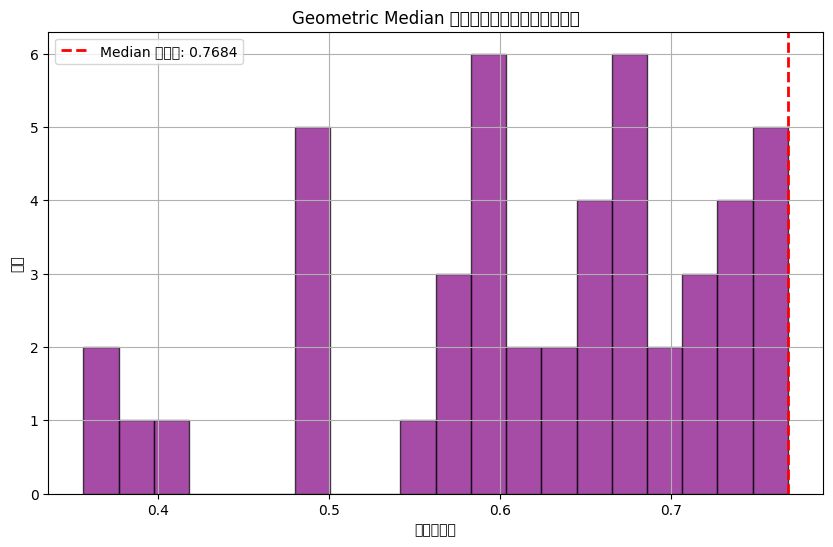

保存几何中位数特征向量...
几何中位数特征已保存到 ./transportation.pt

所有步骤完成。


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def load_features(feature_path, csv_path):
    """
    加载图像特征和文件名。
    """
    if not os.path.exists(feature_path):
        raise FileNotFoundError(f"特征文件 {feature_path} 不存在。")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV 文件 {csv_path} 不存在。")

    features = torch.load(feature_path)  # [num_images, feature_dim]
    df = pd.read_csv(csv_path, index_col=0)  # 假设 CSV 的第一列是索引（文件名）
    filenames = df.columns.tolist()  # 假设 CSV 的列名为图像文件名

    if features.shape[0] != len(filenames):
        raise ValueError("特征数量与文件名数量不匹配。")

    return features, filenames

def geometric_median(X, eps=1e-5, max_iter=500):
    """
    计算几何中位数（Geometric Median）使用 Weiszfeld 算法。

    参数：
        X (ndarray): 输入数据，形状为 [num_samples, num_features]
        eps (float): 收敛阈值
        max_iter (int): 最大迭代次数

    返回：
        median (ndarray): 几何中位数向量，形状为 [num_features]
    """
    y = np.mean(X, axis=0)  # 初始化为质心
    for i in range(max_iter):
        D = np.linalg.norm(X - y, axis=1)
        non_zeros = D > eps
        if not np.any(non_zeros):
            break
        D = D[non_zeros]
        X_non_zeros = X[non_zeros]
        weights = 1 / D
        y_new = np.sum(X_non_zeros * weights[:, np.newaxis], axis=0) / np.sum(weights)
        if np.linalg.norm(y - y_new) < eps:
            y = y_new
            break
        y = y_new
    return y

def compute_cosine_similarities(features, median_vector):
    """
    计算每个特征向量与几何中位数向量的余弦相似度。

    参数：
        features (torch.Tensor): 图像特征，形状为 [num_images, feature_dim]
        median_vector (ndarray): 几何中位数向量，形状为 [feature_dim]

    返回：
        cosine_similarities (ndarray): 余弦相似度数组，形状为 [num_images]
    """
    features_normalized = features / features.norm(dim=1, keepdim=True)
    median_vector_normalized = median_vector / np.linalg.norm(median_vector)
    median_vector_tensor = torch.tensor(median_vector_normalized, dtype=torch.float32)
    cosine_similarities = torch.mm(features_normalized, median_vector_tensor.unsqueeze(1)).squeeze().numpy()
    return cosine_similarities

def visualize_similarity_distribution(cosine_similarities, method_name='Geometric Median'):
    """
    可视化余弦相似度的分布。
    """
    plt.figure(figsize=(10, 6))
    plt.hist(cosine_similarities, bins=20, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(x=cosine_similarities.max(), color='r', linestyle='dashed', linewidth=2, label=f'Median 相似度: {cosine_similarities.max():.4f}')
    plt.xlabel('余弦相似度')
    plt.ylabel('频数')
    plt.title(f'{method_name} 与图像特征的余弦相似度分布')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_geometric_median(median_vector, output_path):
    """
    保存几何中位数向量到 .pt 文件。
    """
    median_tensor = torch.tensor(median_vector, dtype=torch.float32)
    torch.save(median_tensor, output_path)
    print(f"几何中位数特征已保存到 {output_path}")

def main():
    # 定义文件路径
    feature_path = './imgs_vit_transportation.pt'
    csv_path = './cosine_similarity_matrix_transportation.csv'
    median_output = './transportation.pt'

    # 加载特征和文件名
    print("加载图像特征和文件名...")
    try:
        features, filenames = load_features(feature_path, csv_path)
        print(f"加载完成，共有 {features.shape[0]} 张图像，特征维度为 {features.shape[1]}。")
    except Exception as e:
        print(f"加载特征或文件名时出错: {e}")
        return

    # 将特征转换为 NumPy 数组
    features_np = features.numpy()

    # 计算几何中位数
    print("计算几何中位数特征向量...")
    try:
        median_vector = geometric_median(features_np)
        print("几何中位数计算完成。")
    except Exception as e:
        print(f"计算几何中位数时出错: {e}")
        return

    # 计算几何中位数与所有图像特征的余弦相似度
    print("计算几何中位数与所有图像特征的余弦相似度...")
    try:
        cosine_similarities_median = compute_cosine_similarities(features, median_vector)
        average_similarity_median = cosine_similarities_median.mean()
        print(f"几何中位数的平均余弦相似度: {average_similarity_median:.4f}")
    except Exception as e:
        print(f"计算余弦相似度时出错: {e}")

    # 可视化几何中位数与图像特征的余弦相似度分布
    print("可视化几何中位数与图像特征的余弦相似度分布...")
    try:
        visualize_similarity_distribution(cosine_similarities_median, method_name='Geometric Median')
    except Exception as e:
        print(f"可视化余弦相似度分布时出错: {e}")

    # 保存几何中位数特征向量
    print("保存几何中位数特征向量...")
    try:
        save_geometric_median(median_vector, median_output)
    except Exception as e:
        print(f"保存几何中位数特征向量时出错: {e}")

    print("\n所有步骤完成。")

if __name__ == "__main__":
    main()


Loading image features and filenames...
Loaded 208 images with feature dimension 768.
Computing geometric median feature vector...
Geometric median computation completed.
Computing cosine similarities between geometric median and all image features...
Average cosine similarity of geometric median: 0.6366
Visualizing cosine similarity distribution...


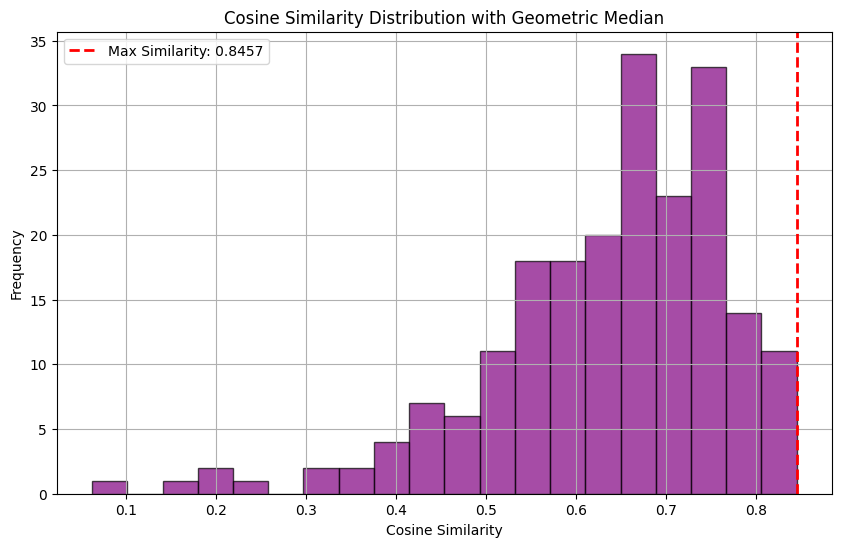

Saving geometric median feature vector...
Geometric median feature saved to ./common_feature_geometric_median.pt
Geometric median feature saved to ./common_feature_geometric_median.csv
Saving cosine similarities to CSV...
Cosine similarities saved to ./cosine_similarities.csv

All steps completed successfully.


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def load_features(feature_path, csv_path):
    """
    Load image features and filenames.

    Args:
        feature_path (str): Path to the .pt file containing image features.
        csv_path (str): Path to the CSV file containing filenames.

    Returns:
        tuple: A tuple containing the features tensor and the list of filenames.
    """
    if not os.path.exists(feature_path):
        raise FileNotFoundError(f"Feature file {feature_path} does not exist.")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file {csv_path} does not exist.")

    # Optional: Set weights_only=True if loading only weights to enhance security
    try:
        features = torch.load(feature_path, weights_only=True)  # [num_images, feature_dim]
    except TypeError:
        # If weights_only is not supported, fallback to default
        features = torch.load(feature_path)  # [num_images, feature_dim]

    df = pd.read_csv(csv_path, index_col=0)  # Assuming the first column is the index (filename)
    filenames = df.columns.tolist()  # Assuming the CSV column names are image filenames

    if features.shape[0] != len(filenames):
        raise ValueError("Number of features does not match number of filenames.")

    return features, filenames

def geometric_median(X, eps=1e-5, max_iter=500):
    """
    Compute the geometric median using the Weiszfeld algorithm.

    Args:
        X (ndarray): Input data, shape [num_samples, num_features].
        eps (float): Convergence threshold.
        max_iter (int): Maximum number of iterations.

    Returns:
        ndarray: Geometric median vector, shape [num_features].
    """
    y = np.mean(X, axis=0)  # Initialize as the centroid
    for i in range(max_iter):
        D = np.linalg.norm(X - y, axis=1)
        non_zeros = D > eps
        if not np.any(non_zeros):
            break
        D = D[non_zeros]
        X_non_zeros = X[non_zeros]
        weights = 1 / D
        y_new = np.sum(X_non_zeros * weights[:, np.newaxis], axis=0) / np.sum(weights)
        if np.linalg.norm(y - y_new) < eps:
            y = y_new
            break
        y = y_new
    return y

def compute_cosine_similarities(features, median_vector):
    """
    Compute cosine similarities between each feature vector and the geometric median vector.

    Args:
        features (torch.Tensor): Image features, shape [num_images, feature_dim].
        median_vector (ndarray): Geometric median vector, shape [feature_dim].

    Returns:
        ndarray: Array of cosine similarities, shape [num_images].
    """
    features_normalized = features / features.norm(dim=1, keepdim=True)
    median_vector_normalized = median_vector / np.linalg.norm(median_vector)
    median_vector_tensor = torch.tensor(median_vector_normalized, dtype=torch.float32)
    cosine_similarities = torch.mm(features_normalized, median_vector_tensor.unsqueeze(1)).squeeze().numpy()
    return cosine_similarities

def visualize_similarity_distribution(cosine_similarities, method_name='Geometric Median'):
    """
    Visualize the distribution of cosine similarities.

    Args:
        cosine_similarities (ndarray): Array of cosine similarities.
        method_name (str): Name of the method used for labeling.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(cosine_similarities, bins=20, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(x=cosine_similarities.max(), color='r', linestyle='dashed', linewidth=2, label=f'Max Similarity: {cosine_similarities.max():.4f}')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title(f'Cosine Similarity Distribution with {method_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_geometric_median(median_vector, output_path_pt, output_path_csv):
    """
    Save the geometric median vector to both .pt and .csv files.

    Args:
        median_vector (ndarray): Geometric median vector.
        output_path_pt (str): Path to save the .pt file.
        output_path_csv (str): Path to save the .csv file.
    """
    # Save as .pt file
    median_tensor = torch.tensor(median_vector, dtype=torch.float32)
    torch.save(median_tensor, output_path_pt)
    print(f"Geometric median feature saved to {output_path_pt}")

    # Save as .csv file
    median_df = pd.DataFrame([median_vector])
    median_df.to_csv(output_path_csv, index=False)
    print(f"Geometric median feature saved to {output_path_csv}")

def save_cosine_similarities(filenames, cosine_similarities, output_path_csv):
    """
    Save the cosine similarities to a CSV file.

    Args:
        filenames (list): List of image filenames.
        cosine_similarities (ndarray): Array of cosine similarities.
        output_path_csv (str): Path to save the CSV file.
    """
    similarities_df = pd.DataFrame({
        'filename': filenames,
        'cosine_similarity': cosine_similarities
    })
    similarities_df.to_csv(output_path_csv, index=False)
    print(f"Cosine similarities saved to {output_path_csv}")

def main():
    # Define file paths
    feature_path = './imgs_vit_commercial.pt'
    csv_path = './cosine_similarity_matrix_commercial.csv'
    median_output_pt = './common_feature_geometric_median.pt'
    median_output_csv = './common_feature_geometric_median.csv'
    cosine_similarities_csv = './cosine_similarities.csv'

    # Configure Matplotlib to handle potential font issues
    plt.rcParams['font.family'] = 'Arial'  # Change to a font that supports necessary glyphs

    # Load features and filenames
    print("Loading image features and filenames...")
    try:
        features, filenames = load_features(feature_path, csv_path)
        print(f"Loaded {features.shape[0]} images with feature dimension {features.shape[1]}.")
    except Exception as e:
        print(f"Error loading features or filenames: {e}")
        return

    # Convert features to NumPy array
    features_np = features.numpy()

    # Compute geometric median
    print("Computing geometric median feature vector...")
    try:
        median_vector = geometric_median(features_np)
        print("Geometric median computation completed.")
    except Exception as e:
        print(f"Error computing geometric median: {e}")
        return

    # Compute cosine similarities between geometric median and all image features
    print("Computing cosine similarities between geometric median and all image features...")
    try:
        cosine_similarities_median = compute_cosine_similarities(features, median_vector)
        average_similarity_median = cosine_similarities_median.mean()
        print(f"Average cosine similarity of geometric median: {average_similarity_median:.4f}")
    except Exception as e:
        print(f"Error computing cosine similarities: {e}")

    # Visualize the distribution of cosine similarities
    print("Visualizing cosine similarity distribution...")
    try:
        visualize_similarity_distribution(cosine_similarities_median, method_name='Geometric Median')
    except Exception as e:
        print(f"Error visualizing cosine similarity distribution: {e}")

    # Save geometric median feature vector to .pt and .csv files
    print("Saving geometric median feature vector...")
    try:
        save_geometric_median(median_vector, median_output_pt, median_output_csv)
    except Exception as e:
        print(f"Error saving geometric median feature vector: {e}")

    # Save cosine similarities to a CSV file
    print("Saving cosine similarities to CSV...")
    try:
        save_cosine_similarities(filenames, cosine_similarities_median, cosine_similarities_csv)
    except Exception as e:
        print(f"Error saving cosine similarities: {e}")

    print("\nAll steps completed successfully.")

if __name__ == "__main__":
    main()


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torch.optim as optim

def load_features(feature_path, csv_path):
    """
    加载图像特征和文件名。
    """
    if not os.path.exists(feature_path):
        raise FileNotFoundError(f"特征文件 {feature_path} 不存在。")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV 文件 {csv_path} 不存在。")

    features = torch.load(feature_path)  # [num_images, feature_dim]
    df = pd.read_csv(csv_path, index_col=0)  # 假设 CSV 的第一列是索引（文件名）
    filenames = df.columns.tolist()  # 假设 CSV 的列名为图像文件名

    if features.shape[0] != len(filenames):
        raise ValueError("特征数量与文件名数量不匹配。")

    return features, filenames

def initialize_common_feature(feature_dim):
    """
    初始化共同特征向量，使用随机初始化并归一化。
    """
    common_feature = torch.randn(feature_dim, requires_grad=True)
    common_feature = common_feature / common_feature.norm()
    return common_feature

def optimize_common_feature(features, common_feature, lr=0.1, epochs=1000, print_every=100):
    """
    优化共同特征向量以最大化与所有图像特征的平均余弦相似度。
    """
    optimizer = optim.Adam([common_feature], lr=lr)
    loss_history = []

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        # 计算余弦相似度
        similarities = torch.mm(features, common_feature.unsqueeze(1)).squeeze()  # [num_images]
        average_similarity = similarities.mean()
        # 目标是最大化平均相似度，因此最小化负平均相似度
        loss = -average_similarity
        loss.backward()
        optimizer.step()
        # 重新归一化
        with torch.no_grad():
            common_feature /= common_feature.norm()

        loss_history.append(average_similarity.item())

        if epoch % print_every == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs}, Average Cosine Similarity: {average_similarity.item():.4f}")

    return common_feature.detach().numpy(), loss_history

def visualize_similarity_history(loss_history):
    """
    可视化优化过程中平均余弦相似度的变化。
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Average Cosine Similarity')
    plt.xlabel('Epoch')
    plt.ylabel('Average Cosine Similarity')
    plt.title('Optimization of Common Feature')
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_cosine_similarities(features, common_feature):
    """
    计算每个特征向量与共同特征向量的余弦相似度。
    """
    features_normalized = features / features.norm(dim=1, keepdim=True)
    common_feature_normalized = common_feature / np.linalg.norm(common_feature)
    common_feature_tensor = torch.tensor(common_feature_normalized, dtype=torch.float32)
    cosine_similarities = torch.mm(features_normalized, common_feature_tensor.unsqueeze(1)).squeeze().numpy()
    return cosine_similarities

def visualize_similarity_distribution(cosine_similarities, method_name='Maximized Similarity'):
    """
    可视化余弦相似度的分布。
    """
    plt.figure(figsize=(10, 6))
    plt.hist(cosine_similarities, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=cosine_similarities.max(), color='r', linestyle='dashed', linewidth=2, label=f'Max Similarity: {cosine_similarities.max():.4f}')
    plt.xlabel('余弦相似度')
    plt.ylabel('频数')
    plt.title(f'{method_name} 与图像特征的余弦相似度分布')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_common_feature(common_feature, output_path):
    """
    保存共同特征向量到 .pt 文件。
    """
    median_tensor = torch.tensor(common_feature, dtype=torch.float32)
    torch.save(median_tensor, output_path)
    print(f"共同特征已保存到 {output_path}")

def main():
    # 定义文件路径
    feature_path = './imgs_vit_commercial.pt'
    csv_path = './cosine_similarity_matrix_commercial.csv'
    common_feature_output = './common_feature_maximized_similarity.pt'

    # 加载特征和文件名
    print("加载图像特征和文件名...")
    try:
        features, filenames = load_features(feature_path, csv_path)
        print(f"加载完成，共有 {features.shape[0]} 张图像，特征维度为 {features.shape[1]}。")
    except Exception as e:
        print(f"加载特征或文件名时出错: {e}")
        return

    # 初始化共同特征向量
    print("初始化共同特征向量...")
    common_feature = initialize_common_feature(features.shape[1])

    # 优化共同特征向量
    print("优化共同特征向量以最大化平均余弦相似度...")
    optimized_common_feature, loss_history = optimize_common_feature(
        features,
        common_feature,
        lr=0.1,
        epochs=1000,
        print_every=100
    )

    # 可视化优化过程
    visualize_similarity_history(loss_history)

    # 计算优化后的余弦相似度
    print("计算优化后的共同特征与所有图像特征的余弦相似度...")
    cosine_similarities = compute_cosine_similarities(features, optimized_common_feature)
    average_similarity = cosine_similarities.mean()
    print(f"优化后的共同特征的平均余弦相似度: {average_similarity:.4f}")

    # 可视化余弦相似度分布
    visualize_similarity_distribution(cosine_similarities, method_name='Maximized Similarity')

    # 保存优化后的共同特征向量
    print("保存优化后的共同特征向量...")
    save_common_feature(optimized_common_feature, common_feature_output)

    print("\n所有步骤完成。")

if __name__ == "__main__":
    main()


加载图像特征和文件名...
加载完成，共有 208 张图像，特征维度为 768。
初始化共同特征向量...
优化共同特征向量以最大化平均余弦相似度...


<ipython-input-5-e543d0a1b350>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(feature_path)  # [num_images, feature_dim]


ValueError: can't optimize a non-leaf Tensor